In [6]:
import pandas as pd
import numpy as np
import datetime 
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

# To Plot matplotlib figures inline on the notebook
%matplotlib inline

In [7]:
data = pd.read_csv('Traffic_Crashes_-_Crashes.csv')

# A.) Clean Data

In [8]:
data.dtypes

STATION                object
NAME                   object
DATE                   object
AWND                  float64
PRCP                  float64
SNOW                  float64
SNWD                  float64
TAVG                  float64
CRASH_DATE             object
POSTED_SPEED_LIMIT    float64
WEATHER_CONDITION      object
LIGHTING_CONDITION     object
BEAT_OF_OCCURRENCE    float64
INJURIES_TOTAL        float64
INJURIES_FATAL        float64
COUNTER               float64
CRASH_DATE_ADJ         object
dtype: object

In [9]:
data=data.drop(['STATION','NAME','DATE','CRASH_DATE','POSTED_SPEED_LIMIT','CRASH_DATE_ADJ'], axis=1)


In [10]:
columns = ['WEATHER_CONDITION', 'LIGHTING_CONDITION', 'BEAT_OF_OCCURRENCE']
for col in columns:
    tmp_df = pd.get_dummies(data[col], prefix=col)
    data = pd.concat((data, tmp_df), axis=1)

In [11]:
data=data.drop(['WEATHER_CONDITION','LIGHTING_CONDITION','BEAT_OF_OCCURRENCE'], axis=1)
data=data.drop(['COUNTER'], axis=1)


In [12]:
#data.INJURIES_TOTAL.describe()
data['INJURIES_TOTAL'].apply(lambda x: (x and 0) or x > 1)
data['ACCIDENT_LEVEL']=(data['INJURIES_TOTAL'] > 0).astype(int)
data=data.drop(['INJURIES_TOTAL','INJURIES_FATAL'], axis=1)
#data=data.drop(['WEATHER_CONDITION','LIGHTING_CONDITION','BEAT_OF_OCCURRENCE'], axis=1)
#data['INJURIES_TOTAL'].replace(2.0, 0,inplace=True)

In [13]:
X = data.iloc[:, 0:293]
y = data.ACCIDENT_LEVEL

# B.) Modeling:

## Train, Test, Split 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

## ROC Curves

In [12]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

models = [RandomForestClassifier(n_estimators=25, n_jobs=-1, max_depth=10), DecisionTreeClassifier(max_depth=None), 
          SVC(probability=True), LogisticRegression(C=3.0, class_weights = {0: 1, 1: 3.5} ), SGDClassifier(loss='log', random_state=42, alpha=0.01)]
model_names = ["Random Forest", "Decision Tree",'SVC','Logistic','SGD-Log']

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [13]:
from sklearn.dummy import DummyClassifier

In [115]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

In [17]:
roc_plotting_stuff = []
for clf, name in zip(models, model_names):
    clf.fit(X_train, y_train)
    preds = clf.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, preds[:,1])
    auc_score = auc(fpr, tpr)
    roc_plotting_stuff.append((name, tpr, fpr, auc_score))

In [ ]:
plt.figure(dpi=250)
for name, tpr, fpr, auc_score in roc_plotting_stuff:
    plt.plot(fpr, tpr, label=name+' (auc: %.2f)'%auc_score)
plt.legend(loc='lower right', fontsize=9)
plt.plot([0, 1], [0, 1], color='k', linestyle='--');
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparing ROC Curves");

## Logistic Regression

In [15]:
lm1 = LogisticRegression(C=1000)
lm1.fit(X_train, y_train)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
lm1.score(X_train, y_train)

0.889075593890179

In [17]:
lm1.score(X_test, y_test)

0.8886004197226369

In [18]:
feature = X_train.values
prediction_hard = lm1.predict(feature)

In [19]:
confusion_matrix(y_train, prediction_hard)

array([[123281,      0],
       [ 15381,      0]])

### Grid Search With Logistic Regression

In [20]:
from sklearn.model_selection import GridSearchCV

In [21]:
logitreg1 = LogisticRegression()
parameters = {'penalty': ['l1', 'l2'], 'C': [1,3,5], 'class_weight': [{0: 1, 1: 3}, {0: 1, 1: 3.5},{0: 1, 1: 8},{0: 1, 1: 10}, 'balanced'], 'random_state': [42]}
grid1 = GridSearchCV(logitreg1 , parameters, cv=3, scoring='f1_weighted', n_jobs=1)
grid1.fit(X_train, y_train)


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [1, 3, 5], 'class_weight': [{0: 1, 1: 3}, {0: 1, 1: 3.5}, {0: 1, 1: 8}, {0: 1, 1: 10}, 'balanced'], 'random_state': [42]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [22]:
print(grid1.best_params_, grid1.best_score_)

{'C': 1, 'class_weight': {0: 1, 1: 3.5}, 'penalty': 'l1', 'random_state': 42} 0.8387545327805829


### Best Logistic Regression Results

In [66]:
#The best parameter is but into logitreg1 and do a full run through with confusion_matrix
lm1 = LogisticRegression(C=3, class_weight = {0: 1, 1: 3.5}, penalty = 'l1', random_state = 42)
lm1.fit(X_train, y_train)
feature_Xtrain = X_train.values
feature_Xtest = X_test.values
prediction_hard_train = lm1.predict(feature_Xtrain)
prediction_hard_test = lm1.predict(feature_Xtest)
print(lm1.score(X_train, y_train))
print(lm1.score(X_test, y_test))
print(confusion_matrix(y_train, prediction_hard_train))
print(confusion_matrix(y_test, prediction_hard_test))

0.8808830104859298
0.8792107483611346
[[121548   1733]
 [ 14784    597]]
[[40464   608]
 [ 4975   174]]


In [67]:
import itertools
import seaborn as sns

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges): #plt.cm.Oranges
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = (100*cm.astype('float')) / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[40464   608]
 [ 4975   174]]
Normalized confusion matrix
[[98.52  1.48]
 [96.62  3.38]]


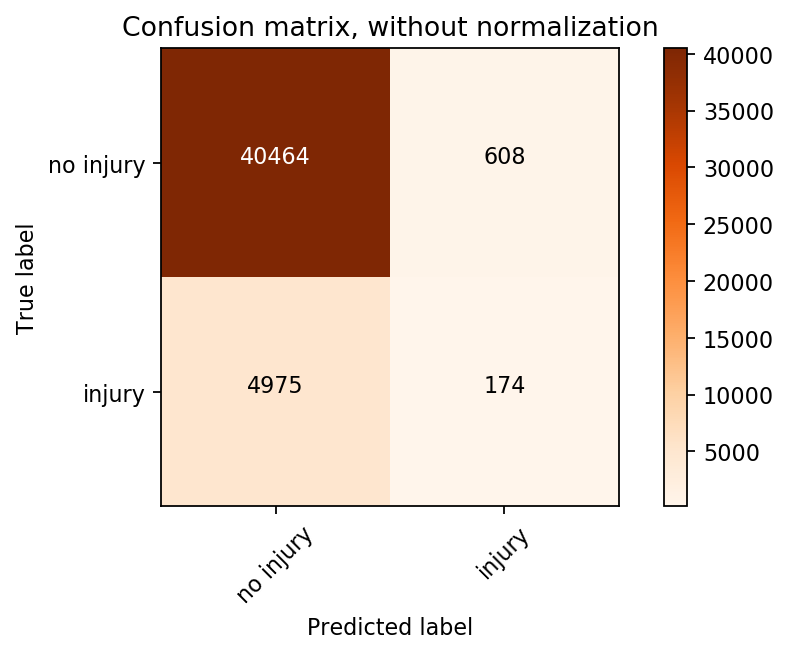

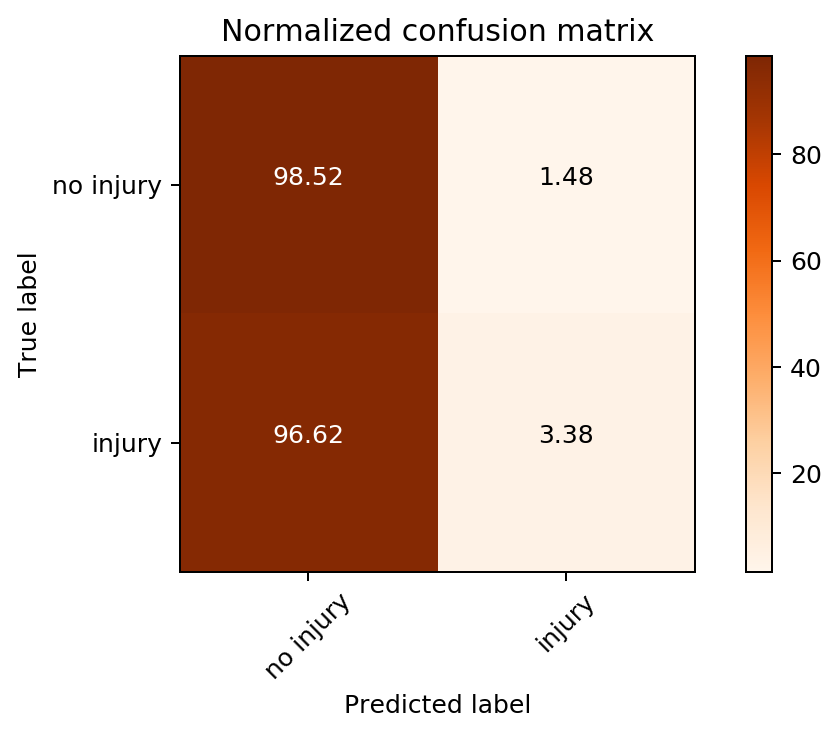

In [68]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, lm1.predict(feature_Xtest))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(dpi=160)
plot_confusion_matrix(cnf_matrix, classes=['no injury', 'injury'], title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(dpi=180)
plot_confusion_matrix(cnf_matrix, classes=['no injury', 'injury'], normalize=True, title='Normalized confusion matrix')

plt.show()

# KNN

In [27]:
from sklearn.neighbors import KNeighborsClassifier

In [28]:
n_neighbors = range(1,7)
knn_accuracy = list()
knn_recall = list()

for n in n_neighbors:
    knn = KNeighborsClassifier(n)
    knn.fit(X_train, y_train)
    knn_prediction = knn.predict(X_test)
    knn_accuracy.append(accuracy_score(y_test, knn_prediction))
    knn_recall.append(recall_score(y_test, knn_prediction))
    

Text(0.5,1,'KNN Model - Accuracy, Recall vs Neighbors')

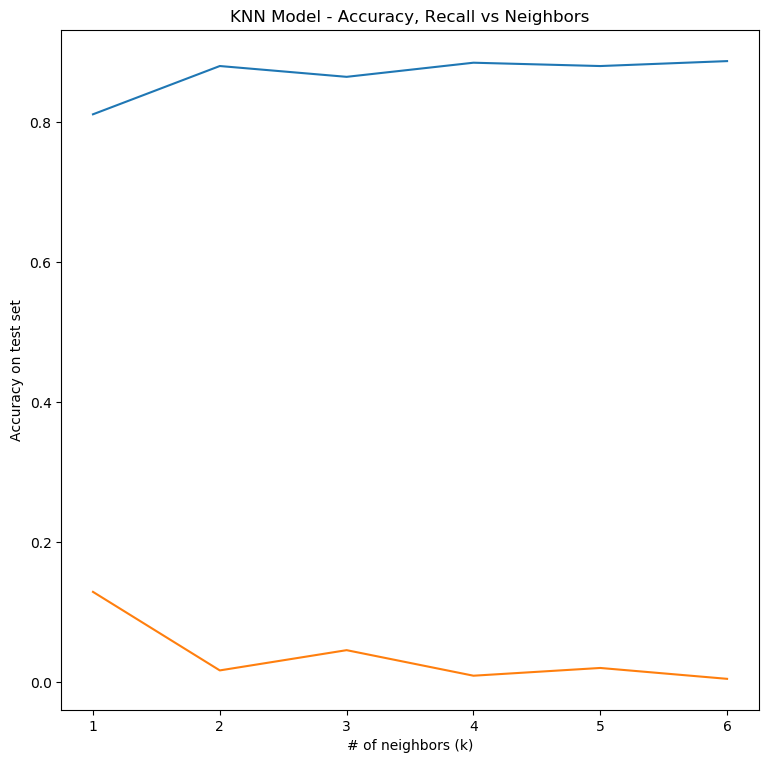

In [29]:
plt.figure(figsize=(9,9), dpi=100)
plt.plot(n_neighbors, knn_accuracy)
plt.plot(n_neighbors, knn_recall)
plt.xlabel('# of neighbors (k)')
plt.ylabel('Accuracy on test set')
plt.title('KNN Model - Accuracy, Recall vs Neighbors')


In [52]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=18) 
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=18, p=2,
           weights='uniform')

In [53]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, knn.predict(X_test))

array([[41072,     0],
       [ 5149,     0]])

### Grid Search With KNN

In [44]:
knn_gs = KNeighborsClassifier()
parameters = {'n_neighbors':[13,15,18,23]}
gridknn = GridSearchCV(knn_gs , parameters, cv=3, scoring='f1_weighted', n_jobs=1)
gridknn.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [13, 15, 18, 23]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [45]:
print(gridknn.best_params_, gridknn.best_score_)

{'n_neighbors': 18} 0.8368445238668536


# SVM

In [210]:
model_svm2 = svm.SVC(kernel='rbf', gamma = 3.0)

In [211]:
model_svm2.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [212]:
y_pred2 = model_svm2.predict(X_test)

In [213]:
accuracy_score(y_test,y_pred2)

0.8839765990027092

In [214]:
confusion_matrix(y_test,y_pred2)

array([[45028,     0],
       [ 5910,     0]])

### Gridsearch with SVM

In [15]:
from sklearn import svm, grid_search

def svc_param_selection(X, y, nfolds):
    Cs = [0.1, 1, 3, 10]
    gammas = [0.1, 1, 5, 10]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [ ]:
svc_param_selection(X_train, y_train, 3)

# Decision Tree

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report



/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [36]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

0.8282815170593453

In [37]:
print(classification_report(y_train, dt.predict(X_train)))

             precision    recall  f1-score   support

          0       0.97      1.00      0.98    123281
          1       0.99      0.75      0.85     15381

avg / total       0.97      0.97      0.97    138662



In [38]:
print(classification_report(y_test, dt.predict(X_test)))

             precision    recall  f1-score   support

          0       0.89      0.92      0.90     41072
          1       0.14      0.11      0.12      5149

avg / total       0.81      0.83      0.82     46221



In [58]:
dt_gs = DecisionTreeClassifier()
parameters = {'max_depth': [5,6,7,8], 'random_state': [3]}
gridknn = GridSearchCV(dt_gs , parameters, cv=3, scoring='f1_weighted', n_jobs=1)
gridknn.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [5, 6, 7, 8], 'random_state': [3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [59]:
print(gridknn.best_params_, gridknn.best_score_)

{'max_depth': 8, 'random_state': 3} 0.836947202166228


In [60]:
dt = DecisionTreeClassifier(max_depth=8)
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

0.8877566474113499

In [61]:
print(classification_report(y_train, dt.predict(X_train)))
print(classification_report(y_test, dt.predict(X_test)))

             precision    recall  f1-score   support

          0       0.89      1.00      0.94    123281
          1       0.83      0.01      0.02     15381

avg / total       0.88      0.89      0.84    138662

             precision    recall  f1-score   support

          0       0.89      1.00      0.94     41072
          1       0.21      0.00      0.01      5149

avg / total       0.81      0.89      0.84     46221



In [62]:
confusion_matrix(y_test, dt.predict(X_test))

array([[41019,    53],
       [ 5135,    14]])

# NB method

In [26]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
nb.score(X_test, y_test)


0.571969451115294

In [61]:
from sklearn.metrics import confusion_matrix, classification_report

In [30]:
print(classification_report(y_train, nb.predict(X_train)))

             precision    recall  f1-score   support

          0       0.91      0.58      0.71    123281
          1       0.14      0.56      0.23     15381

avg / total       0.83      0.58      0.65    138662



In [31]:
print(classification_report(y_test, nb.predict(X_test)))

             precision    recall  f1-score   support

          0       0.91      0.58      0.71     41072
          1       0.14      0.54      0.22      5149

avg / total       0.82      0.57      0.65     46221



In [33]:
print(confusion_matrix(y_train, nb.predict(X_train)))
print(confusion_matrix(y_test, nb.predict(X_test)))

[[71254 52027]
 [ 6747  8634]]
[[23641 17431]
 [ 2353  2796]]


# XGBoosted

In [57]:
import xgboost as xgb


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=41)


In [81]:
gbm = xgb.XGBClassifier(
                       n_estimators=800000, #arbitrary large number
                       max_depth=7,
                       objective='binary:logistic',
                       learning_rate=.08, #.1
                       subsample=1,
                       min_child_weight=6, #
                       colsample_bytree=.8
                      )

eval_set=[(X_train,y_train),(X_val,y_val)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error',
                    early_stopping_rounds=9,
                    verbose=True #gives output log as below
                   )

[0]	validation_0-error:0.1111	validation_1-error:0.110512
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 9 rounds.
[1]	validation_0-error:0.1111	validation_1-error:0.110512
[2]	validation_0-error:0.1111	validation_1-error:0.110512
[3]	validation_0-error:0.1111	validation_1-error:0.110512
[4]	validation_0-error:0.1111	validation_1-error:0.110512
[5]	validation_0-error:0.111091	validation_1-error:0.110512
[6]	validation_0-error:0.11112	validation_1-error:0.110339
[7]	validation_0-error:0.11112	validation_1-error:0.110339
[8]	validation_0-error:0.11112	validation_1-error:0.110339
[9]	validation_0-error:0.11112	validation_1-error:0.110339
[10]	validation_0-error:0.11112	validation_1-error:0.110339
[11]	validation_0-error:0.11112	validation_1-error:0.110339
[12]	validation_0-error:0.11112	validation_1-error:0.110339
[13]	validation_0-error:0.11112	validation_1-error:0.110339
[14]	validatio

In [82]:
accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)) 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8886004197226369

In [83]:
print(classification_report(y_train, gbm.predict(X_train, ntree_limit=gbm.best_ntree_limit)))

             precision    recall  f1-score   support

          0       0.89      1.00      0.94     92440
          1       0.00      0.00      0.00     11556

avg / total       0.79      0.89      0.84    103996



/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [84]:
confusion_matrix(y_train,gbm.predict(X_train, ntree_limit=gbm.best_ntree_limit))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[92440,     0],
       [11556,     0]])

In [64]:
print(classification_report(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)))

             precision    recall  f1-score   support

          0       0.89      1.00      0.94     41072
          1       0.00      0.00      0.00      5149

avg / total       0.79      0.89      0.84     46221



/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [65]:
confusion_matrix(y_test,gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[41072,     0],
       [ 5149,     0]])

In [90]:
from sklearn.model_selection import StratifiedKFold
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot

n_estimators = range(50, 250, 50)
param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(gbm, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot
pyplot.errorbar(n_estimators, means, yerr=stds)
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.savefig('n_estimators.png')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/anaconda3/lib/python3.6/site-packages/t

KeyboardInterrupt: 

In [88]:
from sklearn.model_selection import cross_val_score
import sklearn.metrics as mt

In [89]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

xgb_predictions = xgb.predict(X_test)
                            
#print(xgb.score(X_test, y_test))
scores = cross_val_score(xgb, X_test, y_test, cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(mt.classification_report(y_test, xgb_predictions))
print(mt.confusion_matrix(y_test, xgb_predictions))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

[0.89 0.89 0.89 0.89 0.89]
Accuracy: 0.89 (+/- 0.00)

             precision    recall  f1-score   support

          0       0.89      1.00      0.94     41072
          1       0.00      0.00      0.00      5149

avg / total       0.79      0.89      0.84     46221

[[41072     0]
 [ 5149     0]]


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# RandomForest

In [90]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 20)
rf.fit(X_train, y_train)
       
rf_predictions = rf.predict(X_test)

#print(rf.score(X_test, y_test))
scores = cross_val_score(rf, X_test, y_test, cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(mt.classification_report(y_test, rf_predictions))
print(mt.confusion_matrix(y_test, rf_predictions))

[0.87 0.87 0.87 0.87 0.87]
Accuracy: 0.87 (+/- 0.00)

             precision    recall  f1-score   support

          0       0.89      0.97      0.93     41072
          1       0.14      0.04      0.06      5149

avg / total       0.81      0.87      0.83     46221

[[39874  1198]
 [ 4953   196]]


### GridSearch RandomForest

In [63]:
from sklearn.ensemble import RandomForestClassifier

rfgrid = RandomForestClassifier()
parameters = {'n_estimators': [26,27,28,29], 'random_state': [2]}
gridrf = GridSearchCV(rfgrid , parameters, cv=3, scoring='f1_weighted', n_jobs=1)
gridrf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [26, 27, 28, 29], 'random_state': [2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [64]:
print(gridrf.best_params_, gridrf.best_score_)

{'n_estimators': 28, 'random_state': 2} 0.8321607841759011


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(...
       param_grid={'n_estimators': [20, 25, 30, 35], 'random_state': [2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0) 
****
{'n_estimators': 30, 'random_state': 2} 0.8319949042042862 
****
___

In [ ]:
rf = RandomForestClassifier(n_estimators = 27)
rf.fit(X_train, y_train)
       
rf_predictions = rf.predict(X_test)

#print(rf.score(X_test, y_test))
scores = cross_val_score(rf, X_test, y_test, cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(mt.classification_report(y_test, rf_predictions))
print(mt.confusion_matrix(y_test, rf_predictions))

In [2]:
for ix, label in enumerate(['Male','Female']):
    print(ix)
    print(label)

0
Male
1
Female
2
hi
